In [1]:
#Langchain - Open AI with tools example

# Tools
#loading Arxiv
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="query arxiv papers")
print(arxiv.name)
arxiv.invoke("attention all you need")

arxiv


'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [3]:
api_wraper_wikipedia=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wraper_wikipedia, description="wikipedia search")
wiki.name
wiki.invoke("Sachin Tendulkar")

'Page: Sachin Tendulkar\nSummary: Sachin Ramesh Tendulkar ( ; Marathi: [sətɕin t̪eɳɖulkəɾ]; born 24 April 1973) is an Indian former international cricketer who captained the Indian national team. Often dubbed the "God of Cricket" in India, he is widely regarded as one of the greatest cricketers of all time. He holds several world records, including being the all-time highest run-scorer in international cricket, receiving the most player of the match awards in international cricket, and being the o'

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()
tavily.invoke("Provide me recent news about Gautam Gambhir")

C:\Users\parth\AppData\Local\Temp\ipykernel_10552\3609846894.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


[{'title': 'Latest News on Gautam Gambhir - The Indian Express',
  'url': 'https://indianexpress.com/about/gautam-gambhir/',
  'content': "Gautam Gambhir made his debut in international cricket in 2003, and over the years, he established himself as one of India's finest openers. He played a pivotal role in several significant cricketing moments, most notably in the 2007 ICC World Twenty20 final and the 2011 ICC Cricket World Cup final, where he played crucial innings that led India to victory. Gambhir was known for his tenacity, grit, and determination, which reflected his approach to both cricket and his later foray into politics. [...] follow us on Facebook\nfollow us on Twitter\nfollow us on youtube\nfollow us on Instagram\nThe Indian Express logo\n\n# Gautam Gambhir\n\nGautam Gambhir, the former cricketer turned politician, is a prominent figure in Indian politics, was the Member of Parliament (MP) representing West Delhi. Born on October 14, 1981, in New Delhi, India, Gambhir has 

In [4]:
!pip install langchain-openai

In [7]:
tools = [wiki,tavily,arxiv]

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)


In [9]:
response=llm.invoke("what is latest document in Quantum computing on arxiv?")
print("tool call:",response.tool_calls)

tool call: [{'name': 'arxiv', 'args': {'query': 'Quantum computing'}, 'id': 'call_9lmJfOiXvyxpPxdvaYTsZmsv', 'type': 'tool_call'}]


In [10]:
#print("Response",response)
print("tool call:",response.tool_calls[0]["name"])
print("tool qury:",response.tool_calls[0]["args"])

tool call: arxiv
tool qury: {'query': 'Quantum computing'}


In [11]:
#building workflow in LangGraph
from typing_extensions import TypedDict #for entire State
from langchain_core.messages import AnyMessage #human or AI message
from typing import Annotated  #labeling
from langgraph.graph.message import add_messages #add messages is reducer in langgraph

In [12]:
from IPython.display import display,Image
from langgraph.graph import StateGraph,START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [13]:
# 1. Define the State clearly
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [14]:
from langchain_core.messages.utils import convert_to_openai_messages
def tool_calling_llm(state: State):
    # Automatically handles roles, tool calls, and content blocks
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [15]:
# 2. Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")

# 3. Use the explicit mapping in conditional edges
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END
    }
)

# 4. IMPORTANT: Loop back to LLM after tool execution
builder.add_edge("tools", "tool_calling_llm")

graph_builder = builder.compile()



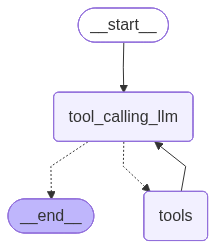

In [16]:
#view graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import HumanMessage
temp_message = graph_builder.invoke(
    {"messages": [HumanMessage(content="What is pydantic library?")]}
)

In [18]:
for m in temp_message["messages"]:
    print(m.pretty_print())

================================ Human Message =================================

What is pydantic library?
None
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_vQJTfVZlU7qHzMW7V2ZZjSRm)
 Call ID: call_vQJTfVZlU7qHzMW7V2ZZjSRm
  Args:
    query: Pydantic
None
================================= Tool Message =================================
Name: wikipedia

Page: FastAPI
Summary: FastAPI is a high-performance web framework for building HTTP-based service APIs in Python 3.8+.  It uses Pydantic and type hints to validate, serialize and deserialize data. FastAPI also automatically generates OpenAPI documentation for APIs built with it. It was first released in 2018.


None
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_KwmFdZmZNYx0GgJMspq0cXn6)
 Call ID: call_KwmFdZmZNYx0GgJMspq0cXn6
  Args:
    query: Pydantic library
None
=========================